# HuggingFace LLM inference experiments

- Compare inference options for quantisation and flash-atten
- As of 01/2024 torch's built in sdpa attention impmenentation has flash-attention without the need for the external lib from Tri Dao (which can be a pain to install). But it's not currently implemented within HF for all models -- particularly there's no support for Mistral
- So still need to use flash-atten lib for now to get flash-attention v2

In [1]:
import json
import os
import sys
import time
from typing import List, Dict, Any

In [2]:
sys.path.append(os.getcwd())

In [3]:
from dotenv import load_dotenv
load_dotenv()

False

In [14]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/dom/.cache/huggingface/token
Login successful


In [40]:
import gc

def cleanup():
    g_keys = globals().keys()
    for k in g_keys:
        if isinstance(globals()[k], torch.nn.Module):
            globals()[k] = None
        gc.collect()
        torch.cuda.empty_cache()

First just load Mistral model with no additional options -- would be just as easy to use their reference implementation but HF gives all the other options for quant etc so go with this

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = "cuda" # the device to load the model onto
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", torch_dtype=torch.float16, device_map=device)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [01:18<00:00, 26.32s/it]


In [8]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [10]:
prompt = "[INST] What is your favourite condiment? [/INST] "
inputs = tokenizer(prompt, return_tensors="pt").to(device)
print(inputs)
generated_ids = model.generate(**inputs, max_new_tokens=256, do_sample=True)
print(generated_ids)
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(outputs)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'input_ids': tensor([[    1,   733, 16289, 28793,  1824,   349,   574, 16020,  2076,  2487,
         28804,   733, 28748, 16289, 28793, 28705]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[    1,   733, 16289, 28793,  1824,   349,   574, 16020,  2076,  2487,
         28804,   733, 28748, 16289, 28793, 28705, 28737,   949, 28742, 28707,
           506,   264,  6656,  2076,  2487,   390,   315,   949, 28742, 28707,
         23327,  2887,   442,  2076,  8447, 28723,  2993, 28725,   315,   541,
          1912,   368,   369,  1287,   905,  3555,  1413,  2076,  8447,   737,
           446,  4455,   715, 28725,  1580,   488, 28725,   579, 28724, 16042,
         28725,  3296, 16042, 28725,   993,  7136,   864, 28725,   304,  1016,
           789,   298,   967, 16859,   304, 27764,   298,   652, 16423, 28723,
             2]], device='cuda:0')
["[INST] What is your favourite condiment? [/INST] I don't have a favorite

In [11]:
messages = [
    {"role": "user", "content": "How were the samples in the sp1200 encoded?"},
    {"role": "assistant", "content": "The samples were encoded in 12-bit PCM."},
    {"role": "user", "content": "What could be done to improve the drum sounds?"},
]

`apply_chat_template` doesn't return `attention_mask` which isn't really a problem here, but we can either generate it manually or first create a string, then tokenize -- this is advised against, but under the hood is probably what `apply_chat_template` is doing anyway...

For llama and mistral, it's easy to use their implementation of sentencepiece tokenizer (see llm-utils for utility funcs)

In [19]:
# tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[    1,     1,   733, 16289, 28793,  1602,   654,   272, 11714,   297,
           272,   668, 28740, 28750, 28734, 28734, 23174, 28804,   733, 28748,
         16289, 28793,  1014, 11714,   654, 23174,   297, 28705, 28740, 28750,
         28733,  2581,  9596, 28755, 28723,     2,   733, 16289, 28793,  1824,
           829,   347,  2203,   298,  4916,   272, 16049,  7258, 28804,   733,
         28748, 16289, 28793]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]], device='cuda:0')}

In [20]:
# encodeds = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
encodeds = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt", ).to(device)
print(encodeds)
attention_mask = torch.ones_like(encodeds)
generated_ids = model.generate(encodeds, attention_mask=attention_mask , max_new_tokens=256, do_sample=True)
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(outputs[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


tensor([[    1,   733, 16289, 28793,  1602,   654,   272, 11714,   297,   272,
           668, 28740, 28750, 28734, 28734, 23174, 28804,   733, 28748, 16289,
         28793,  1014, 11714,   654, 23174,   297, 28705, 28740, 28750, 28733,
          2581,  9596, 28755, 28723,     2,   733, 16289, 28793,  1824,   829,
           347,  2203,   298,  4916,   272, 16049,  7258, 28804,   733, 28748,
         16289, 28793]], device='cuda:0')
[INST] How were the samples in the sp1200 encoded? [/INST]The samples were encoded in 12-bit PCM. [INST] What could be done to improve the drum sounds? [/INST] There are several ways to improve the drum sounds from an SP-1200 or any other digital sampler:

1. Sample Replacement: Replace the original samples with higher quality versions. Better recordings or samples from better sounding sources can greatly improve the overall drum sound.
2. Processing: Apply audio processing effects such as compression, equalization, distortion, and reverb to enhance the dru

same as above but without direct tokenization using the chat template...does make a minor difference to the tokenized output (no space after `\]`) but can be more flexible

In [12]:
prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to(device)
print(inputs)
generated_ids = model.generate(**inputs, max_new_tokens=256, do_sample=True)
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(outputs[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'input_ids': tensor([[    1,     1,   733, 16289, 28793,  1602,   654,   272, 11714,   297,
           272,   668, 28740, 28750, 28734, 28734, 23174, 28804,   733, 28748,
         16289, 28793,  1014, 11714,   654, 23174,   297, 28705, 28740, 28750,
         28733,  2581,  9596, 28755, 28723,     2,   733, 16289, 28793,  1824,
           829,   347,  2203,   298,  4916,   272, 16049,  7258, 28804,   733,
         28748, 16289, 28793]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]], device='cuda:0')}
[INST] How were the samples in the sp1200 encoded? [/INST]The samples were encoded in 12-bit PCM. [INST] What could be done to improve the drum sounds? [/INST]There are several ways to improve the drum sounds from samples loaded in an Akai MPC60 or SP-1200:

1. Editing: Adjusting the attack, decay, sustain, and rele

In [ ]:
%timeit -r 2 model.generate(**inputs, max_new_tokens=256, do_sample=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


16.2 s ± 304 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [13]:
# Note: this ignores the difference between prompt and generated tokens, but as long as we're comparing like for like
# it's good enough for these purposes. I'm not setting temperature=0 either, but we have the same max_tokens.
# Should find the time for each part separately for a more accurate comparison.
def calculate_average_duration(inputs, model, n_repeats=2, max_new_tokens=256):
    total_duration = 0
    total_tps = 0
    for _ in range(n_repeats):
        start = time.time()
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True)
        end = time.time()
        duration = end - start
        total_duration += duration
        total_tps += len(generated_ids[0]) / duration
        print(f"duration: {duration:.2f}, t/s: {len(generated_ids[0]) / duration:.2f}")
    print(f"Averages for prompt and generated | duration: {total_duration / n_repeats:.2f}, t/s: {total_tps / n_repeats:.2f}")

In [14]:
# options for rough benchmarks
n_repeats = 2
total_duration = 0
total_tps = 0

In [26]:
calculate_average_duration(inputs, model)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


duration: 16.30, t/s: 18.96
duration: 16.30, t/s: 18.95
Averages for prompt and generated | duration: 16.30, t/s: 18.95


Quick test for 2 repeats on the inputs defined above gives:

- duration: 16.44 t/s: 18.80
- duration: 16.49 t/s: 18.74
- Averages for prompt and generated | duration: 16.47 t/s: 18.77


## Flash Attention v2

In [20]:
# check that the variable `model` exists and if it does, delete it
cleanup()

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    device_map=device,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)

Loading checkpoint shards: 100%|██████████| 3/3 [01:06<00:00, 22.01s/it]


In [21]:
generated_ids = model.generate(**inputs, max_new_tokens=256, do_sample=True)
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(outputs[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] How were the samples in the sp1200 encoded? [/INST]The samples were encoded in 12-bit PCM. [INST] What could be done to improve the drum sounds? [/INST] There are several ways to improve drum sounds using the SP-1200 or any other digital sampling workstation:

1. Sample selection: Choosing high-quality source material to begin with is crucial. High-end microphones, pre-amps, and interfaces can make a significant difference in the final sound.

2. Sample editing: Manipulating the samples to tailor them to your needs. This includes trimming, pitch shifting, reverse, and time-stretching.

3. Sample processing: Applying various effects to enhance or change the sound. Equalization, compression, and reverb are some of the most common effects.

4. Sequencing: Arranging the sounds in a pleasing way to create a groove or rhythm.

5. Layering: Combining multiple samples to create complex drum sounds and textures.

6. Tuning and timing: Making sure the drum sounds are in tune and in time.


In [24]:
calculate_average_duration(inputs, model)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


duration: 20.21, t/s: 15.29
duration: 20.23, t/s: 15.27
Averages for prompt and generated | duration: 20.22, t/s: 15.28


Example speedups from benchmarks run by Hugging Face on a similar architecture

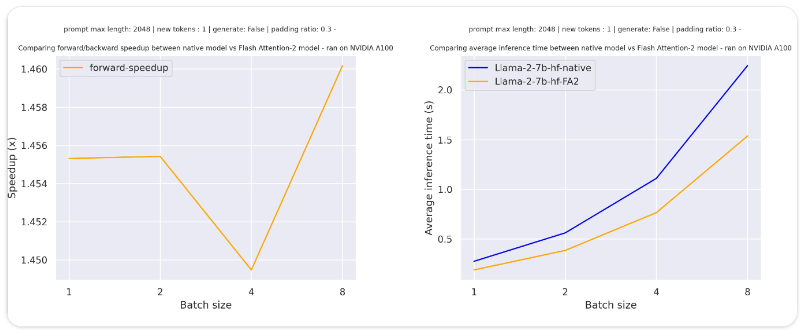

At time of writing, although pytorch has built in sdpa that can use flash-attention under the hood without any additional dependencies, it isn't fully integrated with transformers, optimum, bettertransformers pipeline (only parts). Soon.

This code below would make use of that for the Mistral model. It has support for older models, but we'll keep rolling with Mistral

In [ ]:
# model.to_bettertransformer()

# input_text = "Hello my dog is cute and"
# inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

# with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
#     outputs = model.generate(**inputs)

# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

## Quantisation

Use bitsandbytes to use 4-bit and 8-bit quantisation

In [50]:
from transformers import BitsAndBytesConfig

# load model in 4-bit
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [51]:
cleanup()

prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# single GPU
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", quantization_config=quantization_config)

Loading checkpoint shards: 100%|██████████| 3/3 [01:17<00:00, 25.93s/it]


In [52]:
# # multi GPU with manual memory placement

# max_memory_mapping = {0: "600MB", 1: "1GB"}
# model_4bit = AutoModelForCausalLM.from_pretrained(
#     model_name, device_map="auto", load_in_4bit=True, max_memory=max_memory_mapping
# )

In [43]:
generated_ids = model.generate(**inputs, max_new_tokens=256, do_sample=True)
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(outputs[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] How were the samples in the sp1200 encoded? [/INST]The samples were encoded in 12-bit PCM. [INST] What could be done to improve the drum sounds? [/INST] There are several ways to improve drum sounds, regardless of the original encoding method:

1. Sampling Replacement: Replace the original drum samples with higher-quality samples from better sources.
2. Sample Editing: Edit the samples to remove noise, unwanted artifacts, or inconsistencies. Adjusting the transient response, tuning, and equalization can also help improve the drum sounds.
3. Layering: Combine multiple samples together to create more complex and nuanced drum sounds. This can be used to create a better-quality, more realistic drum sound.
4. Processing: Apply various effects such as compression, distortion, reverb, filtering, and equalization to shape the sound of the drums.
5. MIDI Drum Replacement: Use a MIDI drum virtual instrument to replace the original drum sounds with high-quality samples from a library or sy

In [53]:
calculate_average_duration(inputs, model)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


duration: 14.82, t/s: 20.85
duration: 14.06, t/s: 21.97
Averages for prompt and generated | duration: 14.44, t/s: 21.41


We get speadup compared with no-quant and flash-attention (most likely because the small sequence length and batch size aren't taking advantage of it).

Model loads in ~5GB compared with ~15GB without quant, but I'm not evaluating loss in generation quality here



In [45]:
cleanup()

# load model in 8-bit
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16
)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", quantization_config=quantization_config)

Loading checkpoint shards: 100%|██████████| 3/3 [01:19<00:00, 26.43s/it]


In [46]:
generated_ids = model.generate(**inputs, max_new_tokens=256, do_sample=True)
outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(outputs[0])
calculate_average_duration(inputs, model)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] How were the samples in the sp1200 encoded? [/INST]The samples were encoded in 12-bit PCM. [INST] What could be done to improve the drum sounds? [/INST]There are several ways to improve drum sounds in a digital audio workstation, especially when working with old sampling instruments like the SP-1200:

1. Sampling higher-quality sources: The quality of the original samples is crucial in achieving good drum sounds. Try using high-quality recordings of real drums or professional drum samples.

2. Sampling at higher resolution: If possible, convert your SP-1200 samples to 16- or 24-bit resolution for increased dynamic range and better sound quality.

3. Re-sampling: Re-sample your SP-1200 samples using a higher-quality sampler or digital audio workstation to improve their resolution and reduce aliasing distortion.

4. Editing and processing: Editing and processing techniques such as normalization, equalization, compression, and applying effects can help improve the overall sound of 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


duration: 65.99, t/s: 4.68
duration: 65.67, t/s: 4.71
Averages for prompt and generated | duration: 65.83, t/s: 4.69


In [47]:
calculate_average_duration(inputs, model)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


duration: 66.43, t/s: 4.65
duration: 65.90, t/s: 4.69
Averages for prompt and generated | duration: 66.16, t/s: 4.67


##  Large model loading

Can use the `accelerate` library to avoid the issue with default pytorch loading the model, and then a saved config dict to load in. This can result in 2x model size params loaded taking 2x model size RAM/VRAM

When using pytorch directly this can be done simply be specifying that model params or tensors are lazy loaded as meta tensors. They are not materialised until used, loaded into or placed on a device explicitly

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)

## Sharded saving and loading

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    model.save_pretrained(tmp_dir, max_shard_size="200MB")
    print(sorted(os.listdir(tmp_dir)))

In [ ]:
# load directly with `from_pretrained`
with tempfile.TemporaryDirectory() as tmp_dir:
    model.save_pretrained(tmp_dir, max_shard_size="200MB")
    new_model = AutoModel.from_pretrained(tmp_dir)

In [ ]:
# or from state dict if not using `from_pretrained`
from transformers.modeling_utils import load_sharded_checkpoint

with tempfile.TemporaryDirectory() as tmp_dir:
    model.save_pretrained(tmp_dir, max_shard_size="200MB")
    load_sharded_checkpoint(model, tmp_dir)